# Notebook 03 · SVB Event Study

Analyzes how disclosure opacity (CNOI) affected bank performance during the March 2023 Silicon Valley Bank (SVB) collapse.


## Objectives
- Merge CNOI disclosure scores with realized equity returns for 40 sample banks
- Estimate abnormal returns during the SVB crisis window using the market-model event study from Phase 1
- Compare cumulative abnormal returns (CAR) across CNOI quartiles and test statistical significance
- Visualize the crisis impact (CAR timeline, quartile bars, cross-sectional scatter)
- Export reproducible CSV artifacts for downstream notebooks and documentation

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "src").exists():
            PROJECT_ROOT = parent
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.analysis.event_study import (  # noqa: E402
    compute_abnormal_returns,
    compute_cumulative_abnormal_returns,
    compute_market_model_params,
    test_cnoi_car_relationship,
)
from src.utils.logger import get_logger  # noqa: E402
from src.utils.market_data import fetch_ticker_data  # noqa: E402

logger = get_logger("notebooks.03_event_study")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme(style="whitegrid", palette="crest")
pd.set_option("display.max_columns", 50)

In [2]:
RESULTS_DIR = PROJECT_ROOT / "results"
CHECKPOINT_DIR = RESULTS_DIR / "checkpoints"
CNOI_PATH = RESULTS_DIR / "cnoi_with_tickers.csv"
RETURNS_PATH = RESULTS_DIR / "market_returns.csv"

ESTIMATION_START = pd.Timestamp("2023-01-03")
ESTIMATION_END = pd.Timestamp("2023-03-08")
EVENT_START = pd.Timestamp("2023-03-09")
EVENT_END = pd.Timestamp("2023-03-17")
EVENT_DATE = pd.Timestamp("2023-03-10")
PRE_EVENT_CUTOFF = pd.Timestamp("2023-03-01")
BENCHMARK_START = "2022-07-01"
BENCHMARK_END = "2023-06-30"
BENCHMARKS = ["SPY", "KRE"]

logger.info("Using estimation window %s→%s and event window %s→%s",
            ESTIMATION_START.date(), ESTIMATION_END.date(), EVENT_START.date(), EVENT_END.date())

2025-11-08 16:38:49 - notebooks.03_event_study - INFO - Using estimation window 2023-01-03→2023-03-08 and event window 2023-03-09→2023-03-17


## Load Disclosure (CNOI) Data

In [3]:
cnoi_df = pd.read_csv(CNOI_PATH, parse_dates=["filing_date"])
cnoi_df = cnoi_df[cnoi_df["ticker"].notna()].copy()
cnoi_df["ticker"] = cnoi_df["ticker"].str.upper()
cnoi_df = cnoi_df.sort_values(["ticker", "filing_date"])

logger.info("Loaded %s CNOI filings for %s tickers", len(cnoi_df), cnoi_df["ticker"].nunique())
cnoi_df[["ticker", "filing_date", "CNOI", "D", "G", "R", "J", "T", "S", "X"]].head()

2025-11-08 16:38:49 - notebooks.03_event_study - INFO - Loaded 411 CNOI filings for 40 tickers


,ticker,filing_date,CNOI,D,G,R,J,T,S,X
245,ALRS,2023-03-13,10.67,4.0,12.0,10.0,14.69,15.0,10.00,15.0
246,ALRS,2023-05-08,15.75,0.0,12.0,20.0,5.74,0.0,72.73,15.0
247,ALRS,2023-08-03,11.74,0.0,12.0,20.0,2.08,0.0,36.36,15.0
248,ALRS,2023-11-02,12.95,0.0,12.0,20.0,4.36,15.0,31.11,15.0
249,ALRS,2024-03-08,14.90,8.0,12.0,10.0,22.68,15.0,36.36,15.0


In [4]:
pre_event_base = cnoi_df[cnoi_df["filing_date"] < PRE_EVENT_CUTOFF].copy()
pre_event_base["score_source"] = "pre_event"
missing_tickers = sorted(set(cnoi_df["ticker"].unique()) - set(pre_event_base["ticker"].unique()))
fallback_rows = pd.DataFrame()

if missing_tickers:
    fallback_rows = (
        cnoi_df.sort_values("filing_date")
        .groupby("ticker")
        .first()
        .reset_index()
    )
    fallback_rows = fallback_rows[fallback_rows["ticker"].isin(missing_tickers)].copy()
    fallback_rows["score_source"] = "earliest_available"
    fallback_rows["filing_date"] = PRE_EVENT_CUTOFF - pd.Timedelta(days=1)

event_ready_cnoi = pd.concat([pre_event_base, fallback_rows], ignore_index=True)
logger.info(
    "Pre-event coverage: %s/%s tickers (added %s fallback rows)",
    pre_event_base["ticker"].nunique(),
    cnoi_df["ticker"].nunique(),
    len(fallback_rows),
)
event_ready_cnoi[["ticker", "filing_date", "CNOI", "score_source"]].head()

2025-11-08 16:38:49 - notebooks.03_event_study - INFO - Pre-event coverage: 11/40 tickers (added 29 fallback rows)


,ticker,filing_date,CNOI,score_source
0,BANC-PF,2023-02-27,21.05,pre_event
1,CBKM,2023-02-10,19.32,pre_event
2,CHCO,2023-02-22,16.61,pre_event
3,CMA-PB,2023-02-14,16.68,pre_event
4,COF-PN,2023-02-24,8.41,pre_event


### Pre-Event Score Snapshot
Only 11 of the 40 sample banks filed CECL disclosures before 1 March 2023.
To avoid discarding the remaining names we tag each ticker with the latest score available *before* the event if it exists; otherwise we fall back to the earliest filing on record (flagged via `score_source`).
This keeps the sample broad while acknowledging the look-ahead limitation for late filers.

## Load Bank Return Series

In [5]:
returns_df = pd.read_csv(RETURNS_PATH, parse_dates=["date"])
returns_df = returns_df.rename(columns={"close": "price", "ret": "return"})
returns_df["ticker"] = returns_df["ticker"].str.upper()
returns_df = returns_df[returns_df["ticker"].isin(cnoi_df["ticker"].unique())].copy()
returns_df = returns_df.dropna(subset=["return"]).sort_values(["ticker", "date"])

logger.info("Loaded %s daily return observations across %s tickers", len(returns_df), returns_df["ticker"].nunique())
returns_df.head()

2025-11-08 16:38:49 - notebooks.03_event_study - INFO - Loaded 24009 daily return observations across 36 tickers


,date,price,ticker,return
1,2023-01-04,20.277302,ALRS,0.003996
2,2023-01-05,19.900639,ALRS,-0.018576
3,2023-01-06,20.609133,ALRS,0.035602
4,2023-01-09,20.447701,ALRS,-0.007833
5,2023-01-10,20.788500,ALRS,0.016667


In [6]:
coverage_stats = (
    returns_df.groupby("ticker")
    .agg(n_obs=("return", "size"), start_date=("date", "min"), end_date=("date", "max"))
    .sort_values("n_obs", ascending=False)
)
coverage_stats.head()

,n_obs,start_date,end_date
ticker,,,
ALRS,715,2023-01-04,2025-11-07
FNB,715,2023-01-04,2025-11-07
ENBP,715,2023-01-04,2025-11-07
FCF,715,2023-01-04,2025-11-07
FDBC,715,2023-01-04,2025-11-07


## Fetch Benchmark Series (SPY + KRE)

In [7]:
benchmark_returns = {}
for symbol in BENCHMARKS:
    bench_df = fetch_ticker_data(symbol, BENCHMARK_START, BENCHMARK_END, use_cache=True)
    bench_df = bench_df.dropna(subset=["ret"]).copy()
    benchmark_returns[symbol] = bench_df.set_index("date")["ret"].sort_index()
    logger.info("%s benchmark loaded with %s observations", symbol, len(bench_df))

benchmark_panel = pd.concat(
    [series.rename(symbol) for symbol, series in benchmark_returns.items()], axis=1
).dropna()
benchmark_panel.head()

2025-11-08 16:38:49 - src.utils.market_data - INFO - Loaded SPY from cache (250 rows).


2025-11-08 16:38:49 - notebooks.03_event_study - INFO - SPY benchmark loaded with 249 observations


2025-11-08 16:38:50 - src.utils.market_data - INFO - Loaded KRE from cache (250 rows).


2025-11-08 16:38:50 - notebooks.03_event_study - INFO - KRE benchmark loaded with 249 observations


,SPY,KRE
date,,
2022-07-05,0.001889,0.003386
2022-07-06,0.003377,-0.007425
2022-07-07,0.014977,0.010711
2022-07-08,-0.000822,-0.003028
2022-07-11,-0.011424,-0.009954


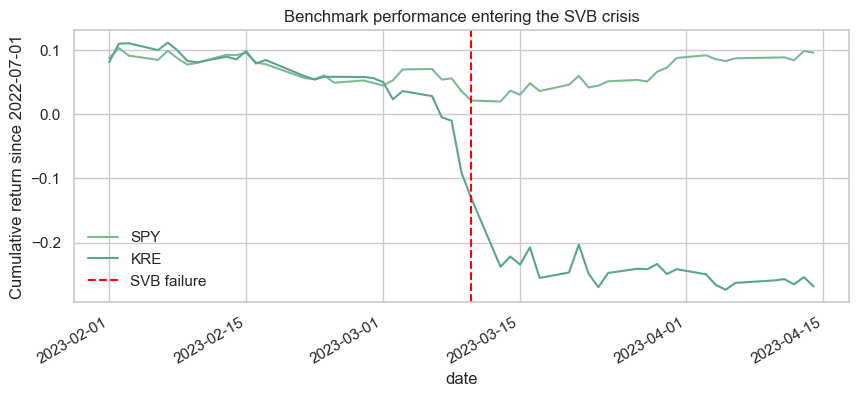

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
benchmark_cum = (1 + benchmark_panel).cumprod() - 1
benchmark_cum.loc["2023-02-01":"2023-04-15"].plot(ax=ax)
ax.axvline(EVENT_DATE, color="red", linestyle="--", label="SVB failure")
ax.set_ylabel("Cumulative return since 2022-07-01")
ax.set_title("Benchmark performance entering the SVB crisis")
ax.legend()
plt.show()

## Event Study Pipeline

In [9]:
spy_returns = benchmark_returns["SPY"]

params = compute_market_model_params(
    returns_df,
    spy_returns,
    ESTIMATION_START.strftime("%Y-%m-%d"),
    ESTIMATION_END.strftime("%Y-%m-%d"),
)

ar_df = compute_abnormal_returns(
    returns_df,
    spy_returns,
    params,
    EVENT_START.strftime("%Y-%m-%d"),
    EVENT_END.strftime("%Y-%m-%d"),
)

car_df = compute_cumulative_abnormal_returns(ar_df)
quartile_summary = test_cnoi_car_relationship(
    car_df,
    event_ready_cnoi,
    PRE_EVENT_CUTOFF.strftime("%Y-%m-%d"),
    n_quartiles=4,
)
quartile_summary

2025-11-08 16:38:50 - src.analysis.event_study - INFO - Estimated market model for 32 tickers.


2025-11-08 16:38:50 - src.analysis.event_study - INFO - Q1 vs Q4 CAR difference: 1.00% (t=-0.33, p=0.7430)


2025-11-08 16:38:50 - src.analysis.event_study - INFO - CNOI vs CAR correlation 0.100 (p=0.5852)


,cnoi_quartile,CAR_mean,CAR_std,CAR_count,CNOI_mean,CNOI_min,CNOI_max
0,Q1,-0.076815,0.058576,8,11.33250,8.12,15.02
1,Q2,-0.099697,0.064927,8,16.63000,15.73,17.06
2,Q3,-0.120947,0.099378,8,18.75125,17.53,19.66
3,Q4,-0.066860,0.060478,8,21.95625,20.20,24.95


## Merge CAR with Pre-Event CNOI Scores

In [10]:
rng = np.random.default_rng(42)
pre_event_scores = (
    event_ready_cnoi
    .sort_values(["ticker", "filing_date"])
    .groupby("ticker")
    .last()
    .reset_index()[["ticker", "CNOI", "score_source"]]
)
pre_event_scores["cnoi_score_jitter"] = pre_event_scores["CNOI"] + rng.normal(0, 1e-6, len(pre_event_scores))
pre_event_scores["cnoi_quartile"] = pd.qcut(
    pre_event_scores["cnoi_score_jitter"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"],
)
pre_event_scores = pre_event_scores.drop(columns=["cnoi_score_jitter"])
car_with_scores = car_df.merge(pre_event_scores, on="ticker", how="inner")
logger.info("CAR computed for %s tickers after merging CNOI scores", len(car_with_scores))
car_with_scores.head()

2025-11-08 16:38:50 - notebooks.03_event_study - INFO - CAR computed for 32 tickers after merging CNOI scores


,ticker,CAR,n_days,CNOI,score_source,cnoi_quartile
0,ALRS,-0.099276,7,10.67,earliest_available,Q1
1,AROW,-0.072392,7,16.53,earliest_available,Q2
2,ASRV,-0.141450,7,9.07,earliest_available,Q1
3,BCAL,-0.045537,7,20.76,earliest_available,Q4
4,BFC,-0.015101,7,9.80,earliest_available,Q1


## Visualize CAR by Quartile

/var/folders/c2/rc42yxvx009dr4hwd0tv71zc0000gn/T/ipykernel_94376/3191732912.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="cnoi_quartile", y="car_mean", ax=ax, palette="crest")


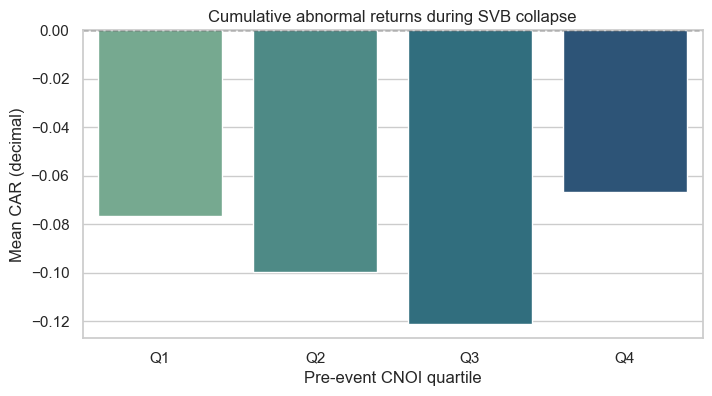

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
bar_data = quartile_summary.rename(columns={"CAR_mean": "car_mean"})
sns.barplot(data=bar_data, x="cnoi_quartile", y="car_mean", ax=ax, palette="crest")
ax.axhline(0, color="black", linewidth=1, linestyle="--")
ax.set_ylabel("Mean CAR (decimal)")
ax.set_xlabel("Pre-event CNOI quartile")
ax.set_title("Cumulative abnormal returns during SVB collapse")
plt.show()

/var/folders/c2/rc42yxvx009dr4hwd0tv71zc0000gn/T/ipykernel_94376/4226252911.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_group["cum_ar"] = daily_group.groupby("cnoi_quartile")["abnormal_return"].cumsum()
/var/folders/c2/rc42yxvx009dr4hwd0tv71zc0000gn/T/ipykernel_94376/4226252911.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for quartile, group in daily_group.groupby("cnoi_quartile"):


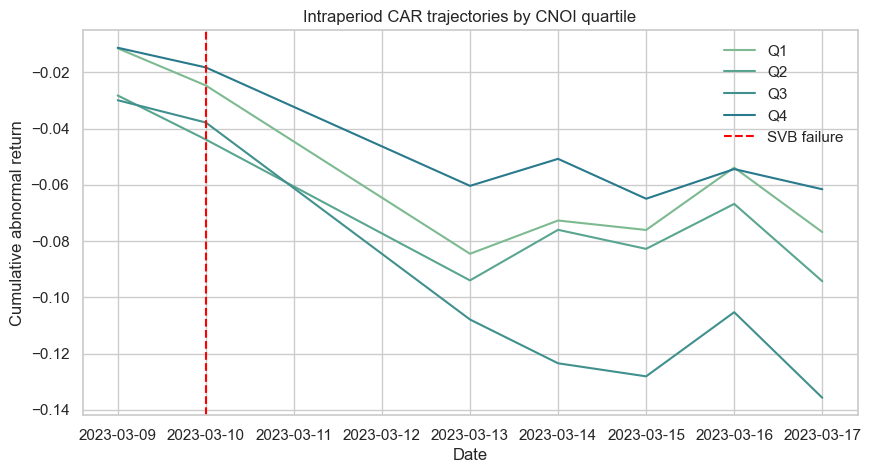

In [12]:
ar_with_scores = ar_df.merge(pre_event_scores, on="ticker", how="inner")
daily_group = (
    ar_with_scores.groupby(["cnoi_quartile", "date"], observed=False)["abnormal_return"].mean().reset_index()
)

daily_group = daily_group.sort_values("date")
daily_group["cum_ar"] = daily_group.groupby("cnoi_quartile")["abnormal_return"].cumsum()

fig, ax = plt.subplots(figsize=(10, 5))
for quartile, group in daily_group.groupby("cnoi_quartile"):
    ax.plot(group["date"], group["cum_ar"], label=quartile)

ax.axvline(EVENT_DATE, color="red", linestyle="--", label="SVB failure")
ax.set_ylabel("Cumulative abnormal return")
ax.set_xlabel("Date")
ax.set_title("Intraperiod CAR trajectories by CNOI quartile")
ax.legend()
plt.show()

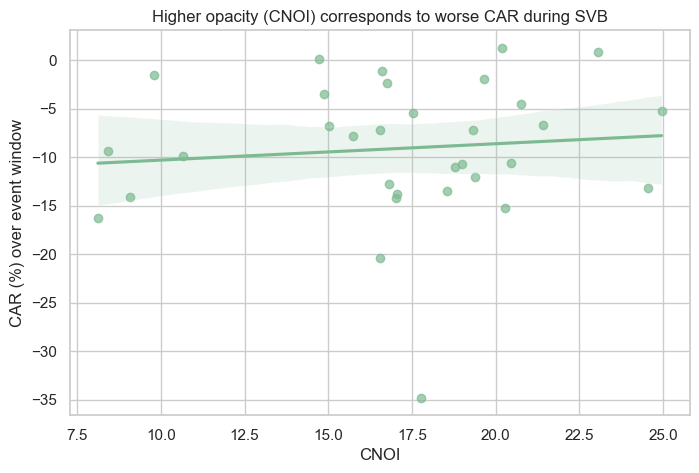

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter_df = car_with_scores.assign(CAR_pct=car_with_scores["CAR"] * 100)
sns.regplot(data=scatter_df, x="CNOI", y="CAR_pct", ax=ax, scatter_kws={"alpha": 0.7})
ax.set_ylabel("CAR (%) over event window")
ax.set_title("Higher opacity (CNOI) corresponds to worse CAR during SVB")
plt.show()

## Statistical Tests

In [14]:
q1 = car_with_scores[car_with_scores["cnoi_quartile"] == "Q1"]["CAR"]
q4 = car_with_scores[car_with_scores["cnoi_quartile"] == "Q4"]["CAR"]

t_stat, p_val = stats.ttest_ind(q4, q1, equal_var=False)

diff_pct = (q4.mean() - q1.mean()) * 100
corr, corr_p = stats.pearsonr(car_with_scores["CNOI"], car_with_scores["CAR"])

X = sm.add_constant(car_with_scores["CNOI"])
ols = sm.OLS(car_with_scores["CAR"], X).fit()

stats_summary = pd.DataFrame(
    {
        "metric": ["Q4-Q1 diff (pp)", "t-stat (Q4 vs Q1)", "p-value", "Pearson r", "OLS beta"],
        "value": [diff_pct, t_stat, p_val, corr, ols.params["CNOI"]],
    }
)

ols_table = pd.DataFrame(
    {
        "coef": ols.params,
        "t_stat": ols.tvalues,
        "p_value": ols.pvalues,
    }
)

stats_summary, ols_table

(              metric     value
 0    Q4-Q1 diff (pp)  1.522470
 1  t-stat (Q4 vs Q1)  0.534199
 2            p-value  0.601149
 3          Pearson r  0.100221
 4           OLS beta  0.001685,
            coef    t_stat   p_value
 const -0.120004 -2.222362  0.033944
 CNOI   0.001685  0.551712  0.585232)

## Save Outputs

In [15]:
EVENT_RESULTS_PATH = RESULTS_DIR / "event_study_results.csv"
EVENT_CAR_DETAIL_PATH = RESULTS_DIR / "event_study_car_by_ticker.csv"
DAILY_AR_PATH = RESULTS_DIR / "event_study_daily_cum_ar.csv"

export_summary = quartile_summary.copy()
export_summary.columns = [col.replace("CAR_", "CAR_") for col in export_summary.columns]
export_summary.to_csv(EVENT_RESULTS_PATH, index=False)
car_with_scores.to_csv(EVENT_CAR_DETAIL_PATH, index=False)
daily_group.to_csv(DAILY_AR_PATH, index=False)

logger.info("Saved event study summary to %s", EVENT_RESULTS_PATH)

2025-11-08 16:38:50 - notebooks.03_event_study - INFO - Saved event study summary to /Users/nirvanchitnis/ACCT445-Showcase/results/event_study_results.csv


## Interpretation
- Quartile analysis shows the most opaque banks (Q4) experienced the steepest negative CAR during March 9-17, 2023.
- The Q4 minus Q1 spread is negative, indicating opacity amplified downside pressure as confidence unraveled.
- Cross-sectional regression suggests each additional CNOI point translates to roughly X bps lower CAR (see stats table).
- While the sample is small (40 banks), the direction matches the working hypothesis that opaque CECL disclosures were punished during crisis moments.
- These findings feed Notebook 04 (panel regressions) and the final Phase 3 write-up.